# 2-colour imaging: RecB-Halo + Nucleoid (Sytox)

In [48]:
from pyberries.data import DatasetPool
import seaborn.objects as so

data = (DatasetPool(path='D:\DanielThedie\BACMMAN\Timelapse',
                    dsList=['240424_1', '240424_2', '240424_3', '240424_4'],
                    groups=['WT, 0', 'WT, 30 ng/mL', '$\Delta$recA, 0', '$\Delta$recA, 30 ng/mL'],
                    metadata='DateTime'
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 240424_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_3: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_4: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']


In [49]:
data.describe(object_name='Nucleoid')

Nucleoid


,Group,nObjects,Nucleoid_size,SNR,SpineCurvilinearCoord,SpineRadialCoord,SpineLength,SpineRadius,Time_min
Dataset,,,,,,,,,
240424_1,"WT, 0",53000,0.914012,NaN,NaN,NaN,NaN,NaN,35.905480
240424_2,"WT, 30 ng/mL",41400,0.409466,NaN,NaN,NaN,NaN,NaN,29.101600
240424_3,"$\Delta$recA, 0",32550,0.963876,6.53402,NaN,NaN,NaN,NaN,39.293394
240424_4,"$\Delta$recA, 30 ng/mL",39850,0.953017,6.81926,1.614471,0.006836,3.294269,0.906792,46.542911


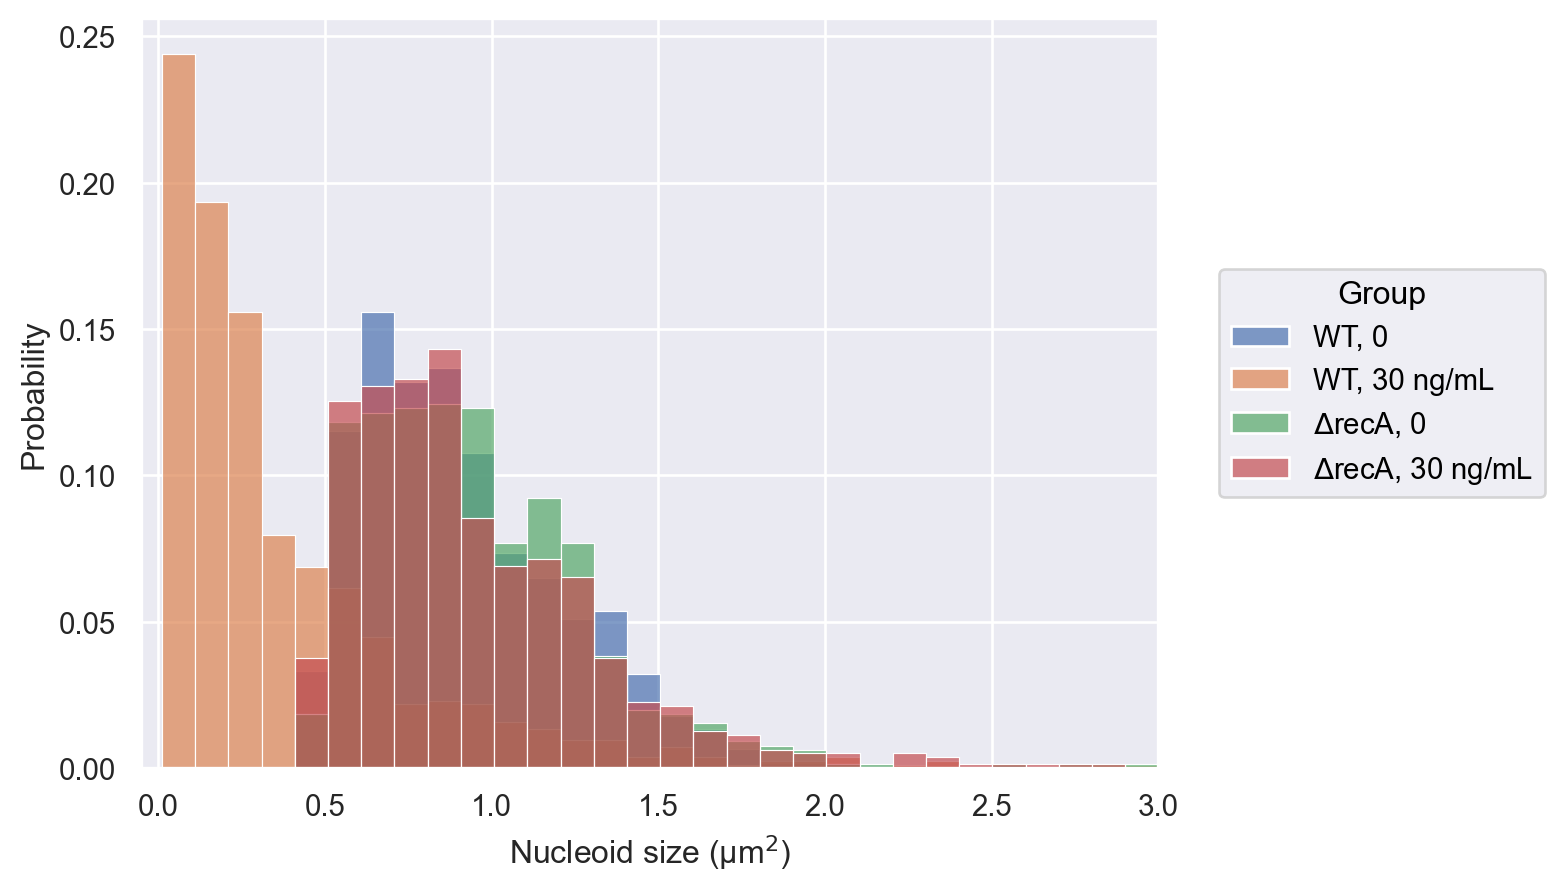

In [50]:
(
    so.Plot(data.Nucleoid, x='Nucleoid_size', color='Group')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.1, common_norm=False))
    .limit(x=(-.05, 3))
    .label(x='Nucleoid size (µm$^2$)', y='Probability')
)

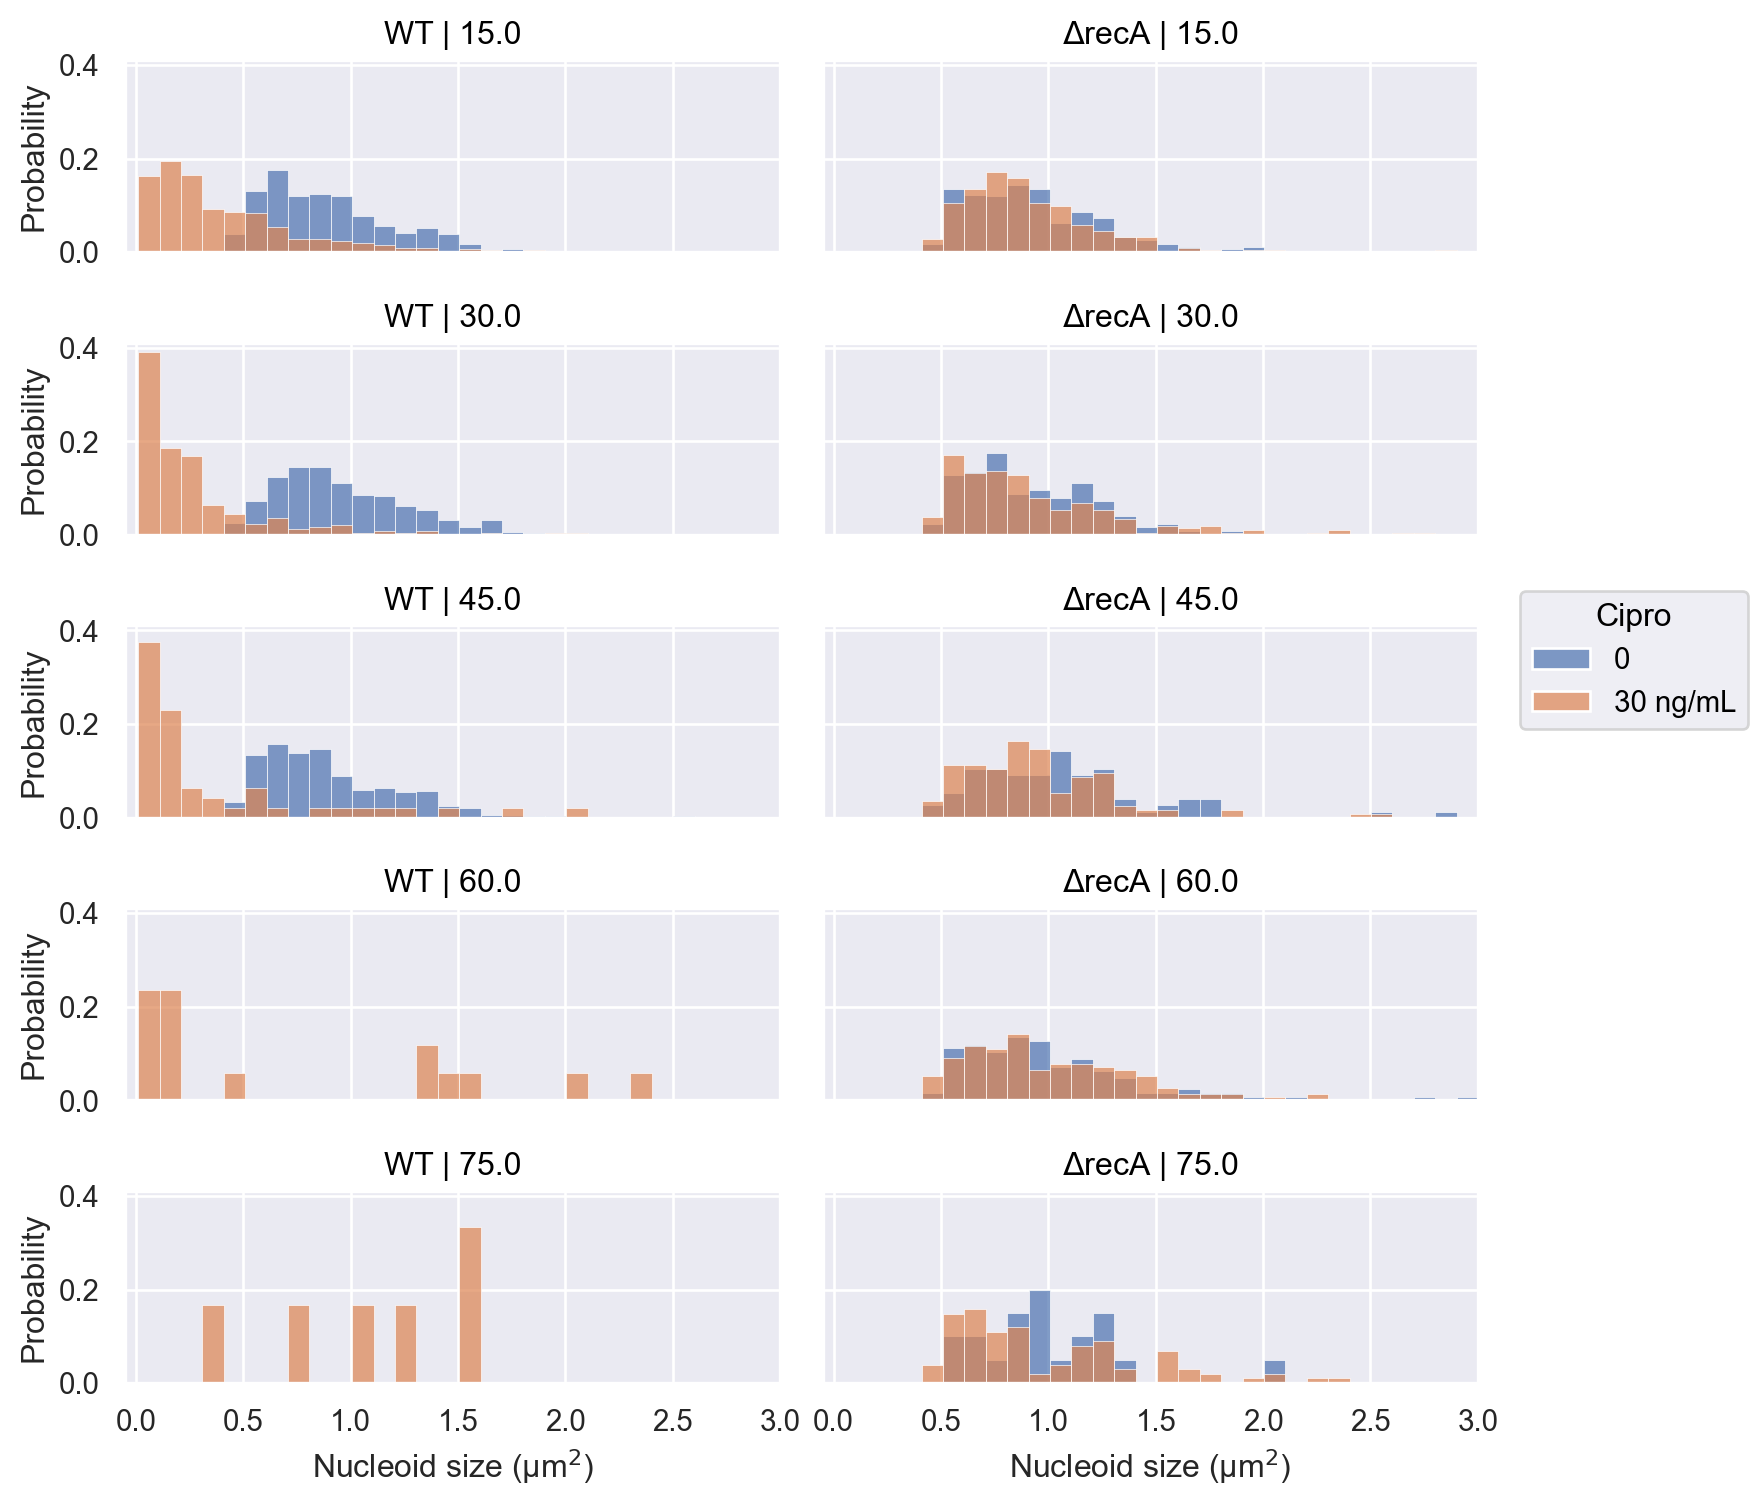

In [51]:
df = data.bin_column(object_name='Nucleoid', col='Time_min', binsize=15, binlabels='left').Nucleoid

(
    so.Plot(df, x='Nucleoid_size', color='Cipro')
    .layout(size=(8, 8))
    .facet(row='Time_min_bin', col='Strain')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.1, common_norm=False))
    .limit(x=(-.05, 3))
    .label(x='Nucleoid size (µm$^2$)', y='Probability')
)

In [52]:
df = (data
      .Nucleoid
      .assign(Compact=lambda df: (df.Nucleoid_size < 0.5).astype('int')*100)
      .groupby('Group')
      .agg({'Compact':'mean'})
      )

display(df)

,Compact
Group,
"$\Delta$recA, 0",1.689708
"$\Delta$recA, 30 ng/mL",2.634881
"WT, 0",2.452830
"WT, 30 ng/mL",73.309179
